In [2]:
import sys
sys.path.append('..')

from util import get_X_y_by_stock, get_tickers, get_currency_pair, load_latest_price_data, convert, add_features, load_pkl, merge_fred, remove_nan
from util import save_pkl, get_pipline_svr, get_pipline_rf

In [3]:
data_dir = '../processed_data_128_0928/'

In [4]:
import logging

logger = logging.getLogger('training')
logger.setLevel(logging.DEBUG)  # Set the logging level

df_train_X_all = load_pkl(f'{data_dir}/df_train_X_all.pkl')
df_train_y_all = load_pkl(f'{data_dir}/df_train_y_all.pkl')
df_test_X_all = load_pkl(f'{data_dir}/df_test_X_all.pkl')
df_test_y_all = load_pkl(f'{data_dir}/df_test_y_all.pkl')
with open(f'{data_dir}/valid_tickers.txt', 'r') as f:
    valid_tickers = f.read().splitlines()
logger.info(f'Data loaded from {data_dir}...')

In [5]:
import logging
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Initialize the logger
logger = logging.getLogger('training')
logger.setLevel(logging.DEBUG)  # Set the logging level

# Load the pickled data
def load_pkl(path):
    return pd.read_pickle(path)

df_train_X_all = load_pkl(f'{data_dir}/df_train_X_all.pkl')
df_train_y_all = load_pkl(f'{data_dir}/df_train_y_all.pkl')
df_test_X_all = load_pkl(f'{data_dir}/df_test_X_all.pkl')
df_test_y_all = load_pkl(f'{data_dir}/df_test_y_all.pkl')
with open(f'{data_dir}/valid_tickers.txt', 'r') as f:
    valid_tickers = f.read().splitlines()

logger.info(f'Data loaded from {data_dir}...')



In [11]:
df_gspc

,predicted_gspc
Date,
1972-11-29,0.031879
1972-11-30,0.032787
1972-12-01,0.036299
1972-12-04,0.031657
1972-12-05,0.036941
...,...
2018-12-24,0.113538
2018-12-26,0.026548
2018-12-27,0.020172


In [14]:
# load the gspc data
df_gspc = pd.read_csv(f'{data_dir}/df_train_pred_rf_gspc.csv', index_col='Date', parse_dates=True)
df_gspc.columns = ['predicted_gspc']
df_train_X_stock = df_train_X_all[0]

# Get the later of the two start dates

df_combined = df_train_X_stock.join(df_gspc, how='left')

start_date = max(df_train_X_stock.index.min(), df_gspc.index.min())

# Cut the combined dataframe to start from the later start date
df_combined = df_combined.loc[start_date:]

# Forward fill missing values in the 'predicted_gspc' column
df_combined['predicted_gspc'] = df_combined['predicted_gspc'].ffill()

# If there are still any NaN values at the beginning, you might want to back fill them
df_combined['predicted_gspc'] = df_combined['predicted_gspc'].bfill()

df_combined



,log_price_diff_1,log_volume_diff_1,log_price_diff_2,log_volume_diff_2,log_price_diff_4,log_volume_diff_4,log_price_diff_8,log_volume_diff_8,log_price_diff_16,log_volume_diff_16,...,UNRATE_diff_8,UNRATE_diff_16,UNRATE_diff_32,FEDFUNDS_diff_1,FEDFUNDS_diff_2,FEDFUNDS_diff_4,FEDFUNDS_diff_8,FEDFUNDS_diff_16,FEDFUNDS_diff_32,predicted_gspc
Date,,,,,,,,,,,,,,,,,,,,,
2001-11-28,0.002379,-0.062795,0.027728,-0.341049,0.028364,-0.269784,0.014024,0.457344,0.096297,-2.319124,...,1.1,1.3,0.9,-0.58,-1.16,-1.48,-3.00,-4.04,-2.27,0.015958
2001-11-29,-0.009539,-0.913866,-0.007160,-0.976662,0.026191,-0.346701,-0.010519,-0.683867,0.017278,-1.856029,...,1.1,1.3,0.9,-0.58,-1.16,-1.48,-3.00,-4.04,-2.27,0.031916
2001-11-30,-0.013659,0.209521,-0.023198,-0.704345,0.004530,-1.045394,-0.024574,-1.423216,0.018674,-0.763377,...,1.1,1.3,0.9,-0.58,-1.16,-1.48,-3.00,-4.04,-2.27,0.027179
2001-12-03,0.031907,0.401508,0.018248,0.611030,0.011088,-0.365632,0.023454,-1.059884,0.056075,-0.024096,...,1.1,1.3,0.9,-0.58,-1.16,-1.48,-3.00,-4.04,-2.27,0.029388
2001-12-04,0.039619,0.056176,0.071526,0.457684,0.048328,-0.246661,0.076692,-0.516445,0.107804,-1.298626,...,1.1,1.3,0.9,-0.58,-1.16,-1.48,-3.00,-4.04,-2.27,0.032763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-19,0.009646,-0.345342,0.008363,-0.923578,-0.061322,0.148751,-0.041123,-0.243890,-0.050261,0.145802,...,-0.2,-0.5,-1.2,0.01,0.25,0.29,0.69,1.05,1.84,0.079991
2018-12-20,-0.016925,0.162233,-0.007279,-0.183109,-0.050371,0.007018,-0.042463,0.145769,-0.067378,0.435299,...,-0.2,-0.5,-1.2,0.01,0.25,0.29,0.69,1.05,1.84,0.041509
2018-12-21,0.002800,1.004051,-0.014125,1.166284,-0.005762,0.242706,-0.058987,1.047678,-0.064979,1.348143,...,-0.2,-0.5,-1.2,0.01,0.25,0.29,0.69,1.05,1.84,0.100666


In [20]:
def combine_stock_gspc(df_stock_X, df_stock_y, df_gspc):
    # Get the later of the two start dates
    df_combined = df_stock_X.join(df_gspc, how='left')
    start_date = max(df_stock_X.index.min(), df_gspc.index.min())
    # Cut the combined dataframe to start from the later start date
    df_combined = df_combined.loc[start_date:]
    df_stock_y = df_stock_y.loc[start_date:]
    # Forward fill missing values in the 'predicted_gspc' column
    df_combined['predicted_gspc'] = df_combined['predicted_gspc'].ffill()
    # If there are still any NaN values at the beginning, you might want to back fill them
    df_combined['predicted_gspc'] = df_combined['predicted_gspc'].bfill()
    return df_combined, df_stock_y

In [32]:
import numpy as np

feature_names = list(df_train_X_all[0].columns) + ["predicted_gspc"]
coefficients = np.zeros(len(feature_names))
for i in range(len(valid_tickers)):
    ticker = valid_tickers[i]
    df_train_X_stock = df_train_X_all[i]
    df_train_y_stock = df_train_y_all[i]
    # concat the gspc data to the d_train_X_stock
    #df_train_X_stock = pd.concat([df_train_X_stock, df_gspc], axis=1)
    
    df_train_X_stock, df_train_y_stock = combine_stock_gspc(df_train_X_stock, df_train_y_stock, df_gspc)

    # scale the features
    scaler = StandardScaler()
    df_train_X_stock = scaler.fit_transform(df_train_X_stock)

    # Apply feature selection using SelectKBest
    #selector = SelectKBest(f_regression, k=5)  # Select 5 best features
    # X_new = selector.fit_transform(df_train_X_stock, df_train_y_stock['log_predict'])

    # Fit linear regression model
    model = LinearRegression()
    model.fit(df_train_X_stock, df_train_y_stock['log_predict'])

    # Get the coefficients of the selected features:
    coefficients += model.coef_

    # Mapping back to feature names (assuming you have a list of feature names)
    

feature_impact = dict(zip(feature_names, coefficients))

df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_stock: 39
df_train_X_st

In [33]:
feature_impact

{'log_price_diff_1': 0.028050802032835494,
 'log_volume_diff_1': -0.23976720243657493,
 'log_price_diff_2': -0.14527115524387865,
 'log_volume_diff_2': -0.16055172688184727,
 'log_price_diff_4': -1.0637680985996822,
 'log_volume_diff_4': -0.5632767420785681,
 'log_price_diff_8': -0.9627849510835077,
 'log_volume_diff_8': -0.19466084036970824,
 'log_price_diff_16': -0.28871290353510454,
 'log_volume_diff_16': -0.17449930557451776,
 'log_price_diff_32': -4.495261003013227,
 'log_volume_diff_32': 0.4942984676596054,
 'log_price_diff_64': -0.928817596552203,
 'log_volume_diff_64': 0.845786034387844,
 'log_price_diff_128': -11.794760090405411,
 'log_volume_diff_128': 0.3726652261435768,
 'log_price_diff_256': -16.604384752733043,
 'log_volume_diff_256': 0.797938629093674,
 'log_price_diff_512': -26.979447875265436,
 'log_volume_diff_512': 0.15034036711211757,
 'log_M2SL_diff_1': -1.7991895374009772,
 'log_M2SL_diff_2': 1.2289832814491977,
 'log_M2SL_diff_4': 11.302725574515556,
 'log_M2SL_d

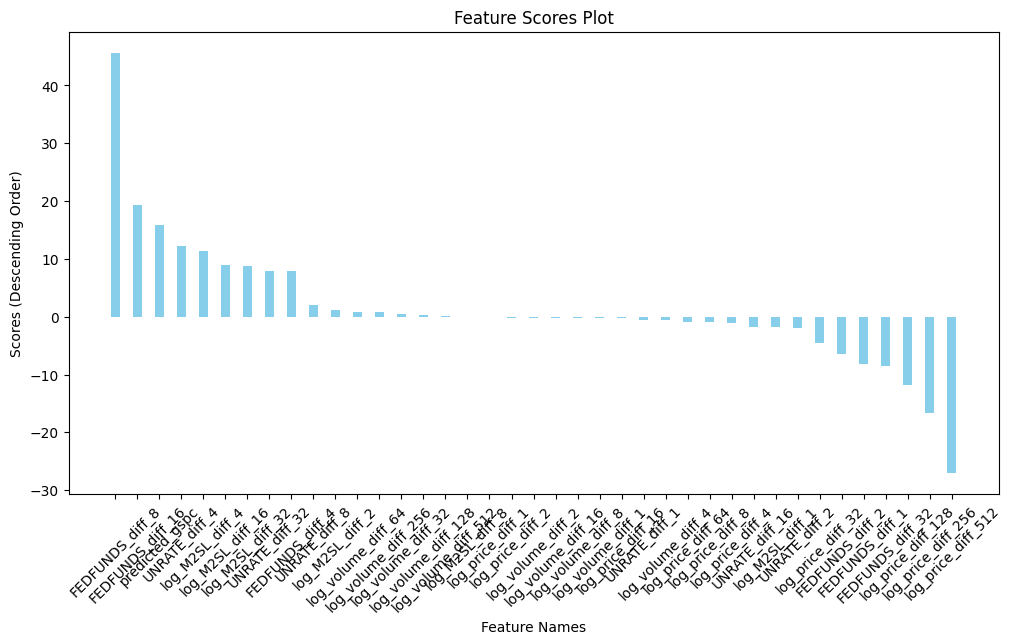

In [35]:
import matplotlib.pyplot as plt



# Assuming selector.scores_ is the array of scores for each feature
scores = coefficients

# Get the scores in descending order
sorted_scores = scores.argsort()[::-1]  # Sort indices in descending order of scores
feature_names = np.array(feature_names)
sorted_features = feature_names[sorted_scores]
sorted_scores = scores[sorted_scores]

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(sorted_features, sorted_scores, color='skyblue',width=0.4)
plt.xlabel('Feature Names')
plt.ylabel('Scores (Descending Order)')
plt.title('Feature Scores Plot')
plt.xticks(rotation=45)  # Rotate feature names for better visibility
plt.show()

In [38]:
scores = coefficients

# Get the scores in descending order
sorted_scores = np.abs(scores).argsort()[::-1]  # Sort indices in descending order of scores
feature_names = np.array(feature_names)
sorted_features = feature_names[sorted_scores]
sorted_features

array(['FEDFUNDS_diff_8', 'log_price_diff_512', 'FEDFUNDS_diff_16',
       'log_price_diff_256', 'predicted_gspc', 'UNRATE_diff_4',
       'log_price_diff_128', 'log_M2SL_diff_4', 'log_M2SL_diff_16',
       'log_M2SL_diff_32', 'FEDFUNDS_diff_32', 'FEDFUNDS_diff_1',
       'UNRATE_diff_32', 'FEDFUNDS_diff_4', 'FEDFUNDS_diff_2',
       'log_price_diff_32', 'UNRATE_diff_8', 'UNRATE_diff_2',
       'log_M2SL_diff_1', 'UNRATE_diff_16', 'log_M2SL_diff_2',
       'log_price_diff_4', 'log_price_diff_8', 'log_price_diff_64',
       'log_volume_diff_64', 'log_volume_diff_256', 'log_volume_diff_4',
       'UNRATE_diff_1', 'log_volume_diff_32', 'log_volume_diff_128',
       'log_price_diff_16', 'log_volume_diff_1', 'log_volume_diff_8',
       'log_volume_diff_16', 'log_volume_diff_2', 'log_volume_diff_512',
       'log_price_diff_2', 'log_M2SL_diff_8', 'log_price_diff_1'],
      dtype='<U19')

In [39]:
# write sorted_features to a file
with open(f'{data_dir}/sorted_features.txt', 'w') as f:
    for item in sorted_features:
        f.write("%s\n" % item)

In [40]:
df_train_X_all = load_pkl(f'{data_dir}/df_train_X_all.pkl')
df_train_y_all = load_pkl(f'{data_dir}/df_train_y_all.pkl')
df_test_X_all = load_pkl(f'{data_dir}/df_test_X_all.pkl')
df_test_y_all = load_pkl(f'{data_dir}/df_test_y_all.pkl')
with open(f'{data_dir}/valid_tickers.txt', 'r') as f:
  valid_tickers = f.read().splitlines()

with open(f'{data_dir}/sorted_features.txt', 'r') as f:
  sorted_features = f.read().splitlines()

In [41]:
for i in range(len(valid_tickers)):
  df_train_X_stock = df_train_X_all[i]
  df_train_y_stock = df_train_y_all[i]
  df_test_X_stock = df_test_X_all[i]
  df_test_y_stock = df_test_y_all[i]
  df_train_X_stock, df_train_y_stock = combine_stock_gspc(df_train_X_stock, df_train_y_stock, df_gspc)
  df_test_X_stock, df_test_y_stock = combine_stock_gspc(df_test_X_stock, df_test_y_stock, df_gspc)


  df_train_X_all[i] = df_train_X_stock[sorted_features]
  df_test_X_all[i] = df_test_X_stock[sorted_features]


In [42]:
df_train_X_all[0]

,FEDFUNDS_diff_8,log_price_diff_512,FEDFUNDS_diff_16,log_price_diff_256,predicted_gspc,UNRATE_diff_4,log_price_diff_128,log_M2SL_diff_4,log_M2SL_diff_16,log_M2SL_diff_32,...,log_volume_diff_128,log_price_diff_16,log_volume_diff_1,log_volume_diff_8,log_volume_diff_16,log_volume_diff_2,log_volume_diff_512,log_price_diff_2,log_M2SL_diff_8,log_price_diff_1
Date,,,,,,,,,,,,,,,,,,,,,
2001-11-28,-3.00,-0.047835,-4.04,0.077474,0.015958,0.8,0.100358,0.031133,0.111959,0.187344,...,0.570780,0.096297,-0.062795,0.457344,-2.319124,-0.341049,0.995540,0.027728,0.062428,0.002379
2001-11-29,-3.00,-0.052123,-4.04,0.069944,0.031916,0.8,0.099807,0.031133,0.111959,0.187344,...,1.245374,0.017278,-0.913866,-0.683867,-1.856029,-0.976662,-0.283304,-0.007160,0.062428,-0.009539
2001-11-30,-3.00,-0.028429,-4.04,0.056164,0.027179,0.8,0.054967,0.031133,0.111959,0.187344,...,-0.424474,0.018674,0.209521,-1.423216,-0.763377,-0.704345,-0.660238,-0.023198,0.062428,-0.013659
2001-12-03,-3.00,0.000623,-4.04,0.097695,0.029388,0.8,0.096396,0.031133,0.111959,0.187344,...,0.604571,0.056075,0.401508,-1.059884,-0.024096,0.611030,-0.216765,0.018248,0.062428,0.031907
2001-12-04,-3.00,0.042375,-4.04,0.178348,0.032763,0.8,0.126680,0.031133,0.111959,0.187344,...,1.045802,0.107804,0.056176,-0.516445,-1.298626,0.457684,-1.286573,0.071526,0.062428,0.039619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-19,0.69,0.383458,1.05,0.079225,0.079991,0.0,-0.031901,0.009004,0.048595,0.126225,...,-0.098094,-0.050261,-0.345342,-0.243890,0.145802,-0.923578,-0.511681,0.008363,0.023837,0.009646
2018-12-20,0.69,0.365955,1.05,0.053153,0.041509,0.0,-0.055607,0.009004,0.048595,0.126225,...,0.380370,-0.067378,0.162233,0.145769,0.435299,-0.183109,0.811381,-0.007279,0.023837,-0.016925
2018-12-21,0.69,0.366039,1.05,0.058473,0.100666,0.0,-0.037392,0.009004,0.048595,0.126225,...,0.974743,-0.064979,1.004051,1.047678,1.348143,1.166284,1.674274,-0.014125,0.023837,0.002800


In [ ]:
import optuna
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error
from safeRegressors import TimeoutException

def objective_random_forest(trial, valid_tickers, df_train_X_all, df_train_y_all):
  # Define the hyperparameter configuration space
  k = trial.suggest_int('k', 5, len(df_train_X_all[0].columns))
  n_estimators = trial.suggest_int('n_estimators', 20, 160)
  max_depth = trial.suggest_int('max_depth', 10, 50)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
  max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
  bootstrap = trial.suggest_categorical('bootstrap', [True, False])
  max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 6, 200)

  params = {"n_estimators": n_estimators, "max_depth": max_depth, \
            "min_samples_split": min_samples_split, \
              "min_samples_leaf": min_samples_leaf, "max_features": max_features, \
                "bootstrap": bootstrap, "max_leaf_nodes": max_leaf_nodes, "k": k}
  
  pipeline = get_pipline_rf(params)

  total_mses = 0
  try:
    for i in range(len(valid_tickers)):
      if i % 100 == 0:
        logger.info(f'Processing {i}th stock...')
      df_train_X = df_train_X_all[i]
      df_train_y = df_train_y_all[i]

      X_train = df_train_X.copy().values
      y_train = df_train_y.copy().values.ravel()
      predictions = cross_val_predict(pipeline, X_train, y_train, cv=5, n_jobs=5)
      mse = mean_squared_error(y_train, predictions)
      total_mses += mse
    
    return total_mses/len(valid_tickers)
  except TimeoutException:
      logger.error("A timeout has occurred during model fitting.")
      # Return a large MSE value to penalize this result
      return float('inf')




study_rf = optuna.create_study()
study_rf.optimize(lambda trial: objective_random_forest(trial, valid_tickers, df_train_X_all, df_train_y_all), 
                    n_trials=10)

In [ ]:



# Iterate through the stocks and select the best features for each
tot_scores = None
for i in range(len(valid_tickers)):
    ticker = valid_tickers[i]
    # Filter the training and testing data for the current stock
    df_train_X_stock = df_train_X_all[i]
    df_train_y_stock = df_train_y_all[i]

    # scale the features
    scaler = StandardScaler()
    df_train_X_stock = scaler.fit_transform(df_train_X_stock)

    # Apply feature selection using SelectKBest
    selector = SelectKBest(f_regression, k=5)  # Select 5 best features
    X_new = selector.fit_transform(df_train_X_stock, df_train_y_stock['log_predict'])

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_new, df_train_y_stock['log_predict'])

    scores = selector.scores_

    # make element-wise addition for tot_scores
    if tot_scores is None:
        tot_scores = scores/len(valid_tickers)
    else:
        tot_scores += scores/len(valid_tickers)

# Get the scores in descending order
feature_names = df_train_X_all[0].columns
sorted_scores = scores.argsort()[::-1]  # Sort indices in descending order of scores
sorted_features = feature_names[sorted_scores]



In [12]:
# Get the scores in descending order
sorted_scores = scores.argsort()[::-1]  # Sort indices in descending order of scores
sorted_features = df_train_X_stock.columns[sorted_scores]
print(sorted_features)

# iterate all tickers, reorder the features based on the scores by descending order
for i in range(len(valid_tickers)):
    ticker = valid_tickers[i]
    df_train_X_all[i] = df_train_X_all[i][sorted_features]



    # Now you have `selected_features_train` and `selected_features_test` which contain the selected features for the current stock.
    # You can continue with training or any further processing here

Index(['log_price_diff_512', 'FEDFUNDS_diff_8', 'FEDFUNDS_diff_4',
       'FEDFUNDS_diff_2', 'UNRATE_diff_16', 'FEDFUNDS_diff_1',
       'UNRATE_diff_32', 'FEDFUNDS_diff_32', 'UNRATE_diff_8', 'UNRATE_diff_4',
       'log_M2SL_diff_16', 'log_M2SL_diff_32', 'log_M2SL_diff_4',
       'log_M2SL_diff_2', 'log_M2SL_diff_1', 'FEDFUNDS_diff_16',
       'log_volume_diff_256', 'UNRATE_diff_2', 'log_price_diff_32',
       'log_price_diff_16', 'log_price_diff_256', 'log_M2SL_diff_8',
       'UNRATE_diff_1', 'log_price_diff_64', 'log_price_diff_8',
       'log_price_diff_128', 'log_volume_diff_128', 'log_price_diff_4',
       'log_price_diff_2', 'log_price_diff_1', 'log_volume_diff_32',
       'log_volume_diff_64', 'log_volume_diff_512', 'log_volume_diff_4',
       'log_volume_diff_8', 'log_volume_diff_16', 'log_volume_diff_1',
       'log_volume_diff_2'],
      dtype='object')


In [13]:
for i in range(len(valid_tickers)):
    ticker = valid_tickers[i]
    # Filter the training and testing data for the current stock
    df_train_X_stock = df_train_X_all[i]
    print(df_train_X_stock.columns)


Index(['log_price_diff_512', 'FEDFUNDS_diff_8', 'FEDFUNDS_diff_4',
       'FEDFUNDS_diff_2', 'UNRATE_diff_16', 'FEDFUNDS_diff_1',
       'UNRATE_diff_32', 'FEDFUNDS_diff_32', 'UNRATE_diff_8', 'UNRATE_diff_4',
       'log_M2SL_diff_16', 'log_M2SL_diff_32', 'log_M2SL_diff_4',
       'log_M2SL_diff_2', 'log_M2SL_diff_1', 'FEDFUNDS_diff_16',
       'log_volume_diff_256', 'UNRATE_diff_2', 'log_price_diff_32',
       'log_price_diff_16', 'log_price_diff_256', 'log_M2SL_diff_8',
       'UNRATE_diff_1', 'log_price_diff_64', 'log_price_diff_8',
       'log_price_diff_128', 'log_volume_diff_128', 'log_price_diff_4',
       'log_price_diff_2', 'log_price_diff_1', 'log_volume_diff_32',
       'log_volume_diff_64', 'log_volume_diff_512', 'log_volume_diff_4',
       'log_volume_diff_8', 'log_volume_diff_16', 'log_volume_diff_1',
       'log_volume_diff_2'],
      dtype='object')
Index(['log_price_diff_512', 'FEDFUNDS_diff_8', 'FEDFUNDS_diff_4',
       'FEDFUNDS_diff_2', 'UNRATE_diff_16', 'FEDFUNDS_d